In [ ]:
#hello worl

Starting NBA Matchup Prediction Tool...
Loading historical NBA data...
Loading current season data...
Column order difference detected! Reordering columns.
Processing data...


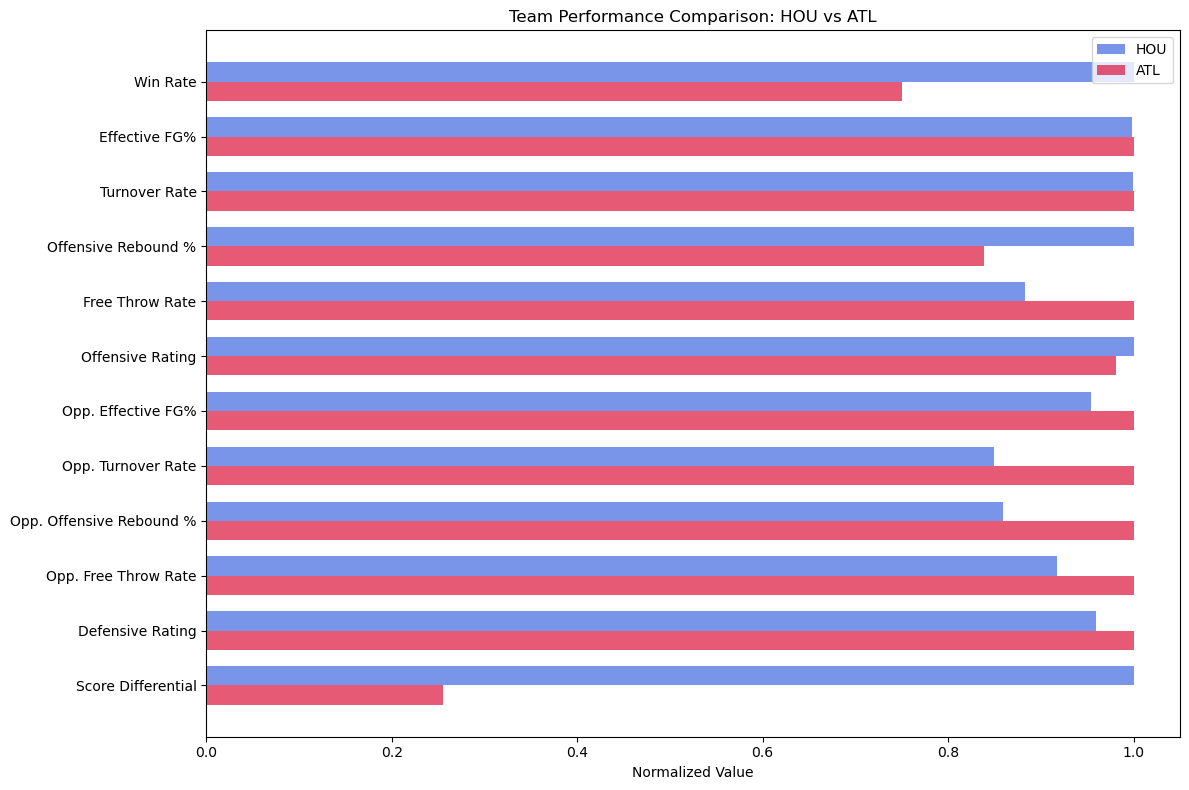

In [2]:
import pandas as pd1
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import MinMaxScaler
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# --- DATA LOADING AND PREPARATION FUNCTIONS ---

def load_data(csv_file):
    """Load NBA game data from CSV file"""
    df = pd.read_csv(csv_file)
    return df

def harmonize_column_order(historical_df, new_df):
    """Harmonize column order between datasets to ensure consistency"""
    # Get the column order of the historical dataset
    historical_columns = historical_df.columns.tolist()
    new_columns = new_df.columns.tolist()
    
    if historical_columns != new_columns:
        print("Column order difference detected! Reordering columns.")
        
        # Ensure all columns exist in both datasets
        common_columns = [col for col in historical_columns if col in new_columns]
        missing_in_new = [col for col in historical_columns if col not in new_columns]
        extra_in_new = [col for col in new_columns if col not in historical_columns]
        
        if missing_in_new:
            print(f"Warning: These columns are missing in the new dataset: {missing_in_new}")
        if extra_in_new:
            print(f"Warning: These columns are only in the new dataset: {extra_in_new}")
        
        # Add missing columns with placeholder data
        for col in missing_in_new:
            if pd.api.types.is_numeric_dtype(historical_df[col]):
                new_df[col] = 0
            else:
                new_df[col] = ""
                
        # Reorder to match historical_columns
        reordered_new_df = new_df[historical_columns]
        return historical_df, reordered_new_df
    
    return historical_df, new_df

def preprocess_data(df):
    """Preprocess data into team-centric format"""
    # Sort by date
    df = df.sort_values("date")
    df = df.reset_index(drop=True)
    
    # Create a unified dataframe with team-based entries
    all_team_games = []
    
    # For each game, create two rows (one for each team)
    for _, row in df.iterrows():
        # Skip rows with missing essential data
        if pd.isnull(row['date']) or pd.isnull(row['visitor_team']) or pd.isnull(row['home_team']):
            continue
        
        try:
            # Home team entry
            home_entry = {
                'date': row['date'],
                'team': row['home_team'],
                'opponent': row['visitor_team'],
                'is_home': 1,
                'won': row['home_win'],
                'pace': row['home_pace'],
                'efg': row['home_efg'],
                'tov_pct': row['home_tov_pct'],
                'orb_pct': row['home_orb_pct'],
                'ft_rate': row['home_ft_rate'],
                'ortg': row['home_ortg'],
                'opp_pace': row['visitor_pace'],
                'opp_efg': row['visitor_efg'],
                'opp_tov_pct': row['visitor_tov_pct'],
                'opp_orb_pct': row['visitor_orb_pct'],
                'opp_ft_rate': row['visitor_ft_rate'],
                'opp_ortg': row['visitor_ortg'],
                'score': row['home_score'],
                'opp_score': row['visitor_score'],
                'score_diff': row['home_score'] - row['visitor_score']
            }
            
            # Away team entry
            away_entry = {
                'date': row['date'],
                'team': row['visitor_team'],
                'opponent': row['home_team'],
                'is_home': 0,
                'won': 1 if row['home_win'] == 0 else 0,  # Inverse of home_win
                'pace': row['visitor_pace'],
                'efg': row['visitor_efg'],
                'tov_pct': row['visitor_tov_pct'],
                'orb_pct': row['visitor_orb_pct'],
                'ft_rate': row['visitor_ft_rate'],
                'ortg': row['visitor_ortg'],
                'opp_pace': row['home_pace'],
                'opp_efg': row['home_efg'],
                'opp_tov_pct': row['home_tov_pct'],
                'opp_orb_pct': row['home_orb_pct'],
                'opp_ft_rate': row['home_ft_rate'],
                'opp_ortg': row['home_ortg'],
                'score': row['visitor_score'],
                'opp_score': row['home_score'],
                'score_diff': row['visitor_score'] - row['home_score']
            }
            
            all_team_games.append(home_entry)
            all_team_games.append(away_entry)
        except Exception as e:
            continue
    
    # Convert to DataFrame
    team_df = pd.DataFrame(all_team_games)
    
    # Extract year from date for grouping
    team_df['year'] = pd.to_datetime(team_df['date']).dt.year
    
    return team_df

def add_target(df):
    """Add target variable (will team win next game?)"""
    # For each team, add target variable (did they win their next game?)
    def process_team(group):
        group = group.sort_values('date')
        group['target'] = group['won'].shift(-1)
        return group
    
    df = df.groupby('team', group_keys=False).apply(process_team)
    
    # Handle NaN values in target
    df['target'] = df['target'].fillna(2)
    df['target'] = df['target'].astype(int)
    
    return df

def add_rolling_stats(df, window=10):
    """Calculate rolling statistics for each team"""
    # Features to calculate rolling averages for
    rolling_features = [
        'won', 'pace', 'efg', 'tov_pct', 'orb_pct', 'ft_rate', 'ortg',
        'opp_pace', 'opp_efg', 'opp_tov_pct', 'opp_orb_pct', 'opp_ft_rate', 'opp_ortg',
        'score_diff'
    ]
    
    try:
        # Calculate rolling stats for each team within each year
        def calculate_rolling(team_year_group):
            team_year_group = team_year_group.sort_values('date')
            
            # Calculate rolling stats
            for feature in rolling_features:
                team_year_group[f'{feature}_rolling'] = team_year_group[feature].rolling(window=window, min_periods=1).mean()
                
            return team_year_group
        
        df = df.groupby(['team', 'year'], group_keys=False).apply(calculate_rolling)
    except Exception as e:
        # Try a more robust approach if the above fails
        teams = df['team'].unique()
        years = df['year'].unique()
        
        processed_dfs = []
        for team in teams:
            for year in years:
                subset = df[(df['team'] == team) & (df['year'] == year)].copy()
                if not subset.empty:
                    subset = subset.sort_values('date')
                    for feature in rolling_features:
                        subset[f'{feature}_rolling'] = subset[feature].rolling(window=window, min_periods=1).mean()
                    processed_dfs.append(subset)
        
        if processed_dfs:
            df = pd.concat(processed_dfs)
    
    return df

def prepare_matchup_features(df):
    """Create features for upcoming matchup"""
    # Add next game info
    def add_next_game_info(team_group):
        team_group = team_group.sort_values('date')
        team_group['opponent_next'] = team_group['opponent'].shift(-1)
        team_group['is_home_next'] = team_group['is_home'].shift(-1)
        team_group['date_next'] = team_group['date'].shift(-1)
        return team_group
    
    df = df.groupby('team', group_keys=False).apply(add_next_game_info)
    
    # Remove rows where next game info is missing
    df = df.dropna(subset=['opponent_next', 'date_next'])
    
    # Prepare to merge with opponent's rolling stats
    matchup_df = df.copy()
    
    # Rename columns for clarity after merge
    rolling_cols = [col for col in matchup_df.columns if '_rolling' in col]
    opponent_cols = {col: f'opp_{col}' for col in rolling_cols}
    
    # Create a version of the dataframe with opponent stats
    opponent_df = matchup_df[['team', 'date'] + rolling_cols].copy()
    opponent_df = opponent_df.rename(columns=opponent_cols)
    
    # Merge team stats with their next opponent's stats
    merged_df = pd.merge(
        matchup_df,
        opponent_df,
        left_on=['opponent_next', 'date_next'],
        right_on=['team', 'date'],
        suffixes=('', '_opp')
    )
    
    return merged_df

# --- PREDICTION AND VISUALIZATION FUNCTIONS ---

def create_matchup_prediction(matchup_data, teams=['GSW', 'ATL'], prediction_date='2025-03-25'):
    """Create a simulated matchup based on recent data"""
    # Filter to only include specified teams most recent games
    team1_games = matchup_data[matchup_data['team'] == teams[0]].sort_values('date')
    team2_games = matchup_data[matchup_data['team'] == teams[1]].sort_values('date')
    
    if team1_games.empty or team2_games.empty:
        return pd.DataFrame()  # Return empty dataframe if data is missing
    
    team1_latest = team1_games.iloc[-1].copy()
    team2_latest = team2_games.iloc[-1].copy()
    
    # Get the rolling columns
    rolling_cols = [col for col in matchup_data.columns if '_rolling' in col]
    
    # Create matchups in both directions
    prediction_rows = []
    
    # Team1 home vs Team2
    team1_home = {
        'date': team1_latest['date'],
        'team': teams[0],
        'opponent': teams[1],
        'is_home': 1,
        'opponent_next': teams[1],
        'is_home_next': 1,  # Team1 at home
        'date_next': prediction_date
    }
    
    # Team2 home vs Team1
    team2_home = {
        'date': team2_latest['date'],
        'team': teams[1],
        'opponent': teams[0],
        'is_home': 1,
        'opponent_next': teams[0],
        'is_home_next': 1,  # Team2 at home
        'date_next': prediction_date + ' alt'  # Different date to distinguish
    }
    
    # Add team's rolling stats
    for col in rolling_cols:
        team1_home[col] = team1_latest[col]
        team2_home[col] = team2_latest[col]
    
    # Add opponent stats
    for col in rolling_cols:
        opp_col = f'opp_{col}'
        team1_home[opp_col] = team2_latest[col]
        team2_home[opp_col] = team1_latest[col]
    
    prediction_rows.append(team1_home)
    prediction_rows.append(team2_home)
    
    # Convert to DataFrame
    prediction_df = pd.DataFrame(prediction_rows)
    
    return prediction_df

def build_model_and_predict(historical_data, matchup_prediction):
    """Build model and predict matchup outcome"""
    if matchup_prediction.empty:
        return pd.DataFrame(), None, None
    
    # Define features and target
    feature_cols = [col for col in historical_data.columns if '_rolling' in col]
    feature_cols.append('is_home_next')
    
    # Prepare training data
    train_df = historical_data.dropna(subset=feature_cols + ['target'])
    
    # Ensure prediction data has all required features
    pred_df = matchup_prediction.copy()
    
    # Check if any features are missing
    missing_cols = [col for col in feature_cols if col not in pred_df.columns]
    if missing_cols:
        for col in missing_cols:
            pred_df[col] = 0.0
    
    # Ensure the order of columns is the same for both dataframes
    train_features_df = train_df[feature_cols].copy()
    pred_features_df = pred_df[feature_cols].copy()
    
    # Scale features
    scaler = MinMaxScaler()
    train_features = scaler.fit_transform(train_features_df)
    pred_features = scaler.transform(pred_features_df)
    
    # Train model
    model = RidgeClassifier(alpha=1.0)
    model.fit(train_features, train_df['target'])
    
    # Make predictions
    pred_df['prediction'] = model.predict(pred_features)
    
    # Calculate feature importance
    if hasattr(model, 'coef_'):
        importance = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': model.coef_[0]
        })
        importance['Abs_Importance'] = abs(importance['Importance'])
        importance = importance.sort_values('Abs_Importance', ascending=False)
    else:
        importance = None
    
    return pred_df, model, importance

def analyze_team_stats(team_data, team1, team2, num_games=10):
    """Analyze recent performance stats for both teams"""
    team1_stats = team_data[team_data['team'] == team1].sort_values('date').tail(num_games)
    team2_stats = team_data[team_data['team'] == team2].sort_values('date').tail(num_games)
    
    if team1_stats.empty or team2_stats.empty:
        return None, None, None
    
    # Calculate key metric averages
    metrics = [
        ('Win Rate', 'won', True),
        ('Effective FG%', 'efg', True),
        ('Turnover Rate', 'tov_pct', False),
        ('Offensive Rebound %', 'orb_pct', True),
        ('Free Throw Rate', 'ft_rate', True),
        ('Offensive Rating', 'ortg', True),
        ('Opp. Effective FG%', 'opp_efg', False),
        ('Opp. Turnover Rate', 'opp_tov_pct', True),
        ('Opp. Offensive Rebound %', 'opp_orb_pct', False),
        ('Opp. Free Throw Rate', 'opp_ft_rate', False),
        ('Defensive Rating', 'opp_ortg', False),
        ('Score Differential', 'score_diff', True)
    ]
    
    comparison = []
    for name, feature, higher_is_better in metrics:
        team1_val = team1_stats[feature].mean()
        team2_val = team2_stats[feature].mean()
        
        if higher_is_better:
            advantage = team1 if team1_val > team2_val else team2
        else:
            advantage = team1 if team1_val < team2_val else team2
        
        margin = abs(team1_val - team2_val)
        
        comparison.append({
            'Metric': name,
            team1: team1_val,
            team2: team2_val,
            'Advantage': advantage,
            'Margin': margin
        })
    
    comparison_df = pd.DataFrame(comparison)
    
    # Count advantages
    team1_advantages = (comparison_df['Advantage'] == team1).sum()
    team2_advantages = (comparison_df['Advantage'] == team2).sum()
    
    return comparison_df, team1_advantages, team2_advantages

def visualize_comparison(comparison_df, team1, team2):
    """Create visual comparison of team metrics"""
    # Create a horizontal bar chart of relative advantages
    metrics = comparison_df['Metric'].tolist()
    team1_vals = comparison_df[team1].tolist()
    team2_vals = comparison_df[team2].tolist()
    
    # Normalize values for better visualization
    normalized_vals = []
    for i in range(len(metrics)):
        max_val = max(abs(team1_vals[i]), abs(team2_vals[i]))
        if max_val == 0:
            normalized_vals.append((0, 0))
        else:
            normalized_vals.append((team1_vals[i]/max_val, team2_vals[i]/max_val))
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Set up bar positions
    y_pos = np.arange(len(metrics))
    bar_height = 0.35
    
    # Plot bars
    ax.barh(y_pos - bar_height/2, [v[0] for v in normalized_vals], bar_height, 
            label=team1, color='royalblue', alpha=0.7)
    ax.barh(y_pos + bar_height/2, [v[1] for v in normalized_vals], bar_height, 
            label=team2, color='crimson', alpha=0.7)
    
    # Customize plot
    ax.set_yticks(y_pos)
    ax.set_yticklabels(metrics)
    ax.invert_yaxis()  # Labels read top-to-bottom
    ax.set_xlabel('Normalized Value')
    ax.set_title(f'Team Performance Comparison: {team1} vs {team2}')
    ax.legend()
    
    plt.tight_layout()
    return fig

def display_prediction_results(predictions, team_data, importance, team1, team2):
    """Display the prediction results in a formatted way"""
    if predictions.empty:
        return HTML(f"<div style='color:red;font-weight:bold;'>Error: Not enough data for {team1} vs {team2}</div>")
    
    # Get team stats
    team1_stats = team_data[team_data['team'] == team1].tail(10)
    team2_stats = team_data[team_data['team'] == team2].tail(10)
    
    if team1_stats.empty or team2_stats.empty:
        return HTML(f"<div style='color:red;font-weight:bold;'>Error: Not enough recent data for {team1} or {team2}</div>")
    
    # Get win-loss records
    team1_wins = team1_stats['won'].sum()
    team1_games = len(team1_stats)
    team2_wins = team2_stats['won'].sum()
    team2_games = len(team2_stats)
    
    # Get prediction results
    team1_home = predictions[predictions['team'] == team1]
    team2_home = predictions[predictions['team'] == team2]
    
    if len(team1_home) > 0 and len(team2_home) > 0:
        team1_home_pred = team1_home['prediction'].values[0]
        team2_home_pred = team2_home['prediction'].values[0]
        
        # Create HTML output
        html_output = f"""
        <div style='font-family: Arial, sans-serif; max-width: 800px;'>
            <h2 style='color: #333;'>{team1} vs {team2} Matchup Prediction</h2>
            
            <div style='background-color: #f5f5f5; padding: 15px; border-radius: 5px; margin-bottom: 20px;'>
                <h3>Recent Performance (Last 10 Games)</h3>
                <div style='display: flex; justify-content: space-between;'>
                    <div style='flex: 1;'>
                        <h4>{team1}</h4>
                        <p>Record: {team1_wins}-{team1_games - team1_wins} ({team1_wins/team1_games:.3f})</p>
                        <p>Offensive Rating: {team1_stats['ortg'].mean():.2f}</p>
                        <p>Defensive Rating: {team1_stats['opp_ortg'].mean():.2f}</p>
                        <p>Effective FG%: {team1_stats['efg'].mean():.3f}</p>
                    </div>
                    <div style='flex: 1;'>
                        <h4>{team2}</h4>
                        <p>Record: {team2_wins}-{team2_games - team2_wins} ({team2_wins/team2_games:.3f})</p>
                        <p>Offensive Rating: {team2_stats['ortg'].mean():.2f}</p>
                        <p>Defensive Rating: {team2_stats['opp_ortg'].mean():.2f}</p>
                        <p>Effective FG%: {team2_stats['efg'].mean():.3f}</p>
                    </div>
                </div>
            </div>
            
            <div style='background-color: #e9f7ef; padding: 15px; border-radius: 5px; margin-bottom: 20px;'>
                <h3>ML Model Prediction</h3>
                <p>{team1} at home vs {team2}: <strong>{'Win' if team1_home_pred == 1 else 'Loss'}</strong></p>
                <p>{team2} at home vs {team1}: <strong>{'Win' if team2_home_pred == 1 else 'Loss'}</strong></p>
                
                <h4>Prediction Summary:</h4>
        """
        
        # Add prediction summary
        if team1_home_pred == 1 and team2_home_pred == 0:
            html_output += f"<p><strong>{team1} strongly favored</strong> - projected to win both at home and away</p>"
        elif team1_home_pred == 0 and team2_home_pred == 1:
            html_output += f"<p><strong>{team2} strongly favored</strong> - projected to win both at home and away</p>"
        elif team1_home_pred == 1 and team2_home_pred == 1:
            html_output += f"<p><strong>Home court advantage is critical</strong> - home team projected to win in both scenarios</p>"
        else:
            html_output += f"<p><strong>Unusual pattern detected</strong> - away team projected to win in both scenarios</p>"
        
        # Determine overall favorite
        if team1_home_pred == team2_home_pred:
            favorite = team1 if team1_home_pred == 1 else team2
            html_output += f"<p>Neutral court projection: <strong>{favorite}</strong> favored to win regardless of venue</p>"
        else:
            html_output += "<p>Neutral court projection: Home court advantage appears to be the deciding factor</p>"
            
        html_output += """
            </div>
            
            <div style='background-color: #ebf5fb; padding: 15px; border-radius: 5px;'>
                <h3>Key Matchup Factors</h3>
        """
        
        # Add key matchup factors
        html_output += f"""
                <p><strong>1. Offensive Efficiency:</strong><br>
                   {team1} ORTG: {team1_stats['ortg'].mean():.2f} vs {team2} ORTG: {team2_stats['ortg'].mean():.2f}
                   <br><em>{team1 if team1_stats['ortg'].mean() > team2_stats['ortg'].mean() else team2} has a 
                   {abs(team1_stats['ortg'].mean() - team2_stats['ortg'].mean()):.2f} point offensive advantage</em></p>
                
                <p><strong>2. Defensive Efficiency:</strong><br>
                   {team1} Defensive RTG: {team1_stats['opp_ortg'].mean():.2f} vs {team2} Defensive RTG: {team2_stats['opp_ortg'].mean():.2f}
                   <br><em>{team1 if team1_stats['opp_ortg'].mean() < team2_stats['opp_ortg'].mean() else team2} has a 
                   {abs(team1_stats['opp_ortg'].mean() - team2_stats['opp_ortg'].mean()):.2f} point defensive advantage</em></p>
                
                <p><strong>3. Four Factors:</strong><br>
                   <strong>Shooting:</strong> {team1} eFG%: {team1_stats['efg'].mean():.3f}, {team2} eFG%: {team2_stats['efg'].mean():.3f}<br>
                   <strong>Turnovers:</strong> {team1}: {team1_stats['tov_pct'].mean():.2f}%, {team2}: {team2_stats['tov_pct'].mean():.2f}%<br>
                   <strong>Rebounding:</strong> {team1} ORB%: {team1_stats['orb_pct'].mean():.2f}%, {team2} ORB%: {team2_stats['orb_pct'].mean():.2f}%<br>
                   <strong>Free Throws:</strong> {team1} FT Rate: {team1_stats['ft_rate'].mean():.3f}, {team2} FT Rate: {team2_stats['ft_rate'].mean():.3f}</p>
        """
        
        # Add feature importance if available
        if importance is not None:
            html_output += """
                <h3>Top Model Features</h3>
                <table style='width: 100%; border-collapse: collapse;'>
                    <tr style='background-color: #ddd;'>
                        <th style='padding: 8px; text-align: left; border: 1px solid #ccc;'>Feature</th>
                        <th style='padding: 8px; text-align: left; border: 1px solid #ccc;'>Importance</th>
                    </tr>
            """
            
            for _, row in importance.head(5).iterrows():
                html_output += f"""
                    <tr>
                        <td style='padding: 8px; border: 1px solid #ccc;'>{row['Feature']}</td>
                        <td style='padding: 8px; border: 1px solid #ccc;'>{row['Importance']:.4f}</td>
                    </tr>
                """
            
            html_output += "</table>"
        
        html_output += """
            </div>
        </div>
        """
        
        return HTML(html_output)
    else:
        return HTML(f"<div style='color:red;font-weight:bold;'>Error: Could not generate predictions for {team1} vs {team2}</div>")

# --- MAIN INTERACTIVE FUNCTION ---

def setup_interactive_prediction():
    """Set up and return interactive widgets for team selection"""
    # Load and process data
    print("Loading historical NBA data...")
    historical_data = load_data('nba_games_stats.csv')
    print("Loading current season data...")
    current_data = load_data('converted_report.csv')
    
    # Harmonize column order 
    historical_data, current_data = harmonize_column_order(historical_data, current_data)
    
    # Combine datasets
    combined_data = pd.concat([historical_data, current_data])
    
    # Process data
    print("Processing data...")
    team_data = preprocess_data(combined_data)
    team_data = add_target(team_data)
    team_data = add_rolling_stats(team_data, window=10)
    matchup_data = prepare_matchup_features(team_data)
    
    # Get all team names for dropdowns
    team_list = sorted(team_data['team'].unique())
    
    # Create widgets
    team1_dropdown = widgets.Dropdown(
        options=team_list,
        value='GSW',
        description='Team 1:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='250px')
    )
    
    team2_dropdown = widgets.Dropdown(
        options=team_list,
        value='ATL',
        description='Team 2:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='250px')
    )
    
    predict_button = widgets.Button(
        description='Predict Matchup',
        button_style='success',
        layout=widgets.Layout(width='200px')
    )
    
    output_area = widgets.Output()
    
    def on_predict_button_clicked(b):
        """Handle predict button click"""
        with output_area:
            clear_output()
            
            team1 = team1_dropdown.value
            team2 = team2_dropdown.value
            
            if team1 == team2:
                display(HTML(f"<div style='color:red;font-weight:bold;'>Error: Please select two different teams</div>"))
                return
            
            print(f"Analyzing {team1} vs {team2} matchup...")
            
            # Create prediction
            prediction_matchups = create_matchup_prediction(matchup_data, teams=[team1, team2])
            predictions, model, importance = build_model_and_predict(matchup_data, prediction_matchups)
            
            # Display results
            display(display_prediction_results(predictions, team_data, importance, team1, team2))
            
            # Display comparison visualization
            comparison_df, team1_adv, team2_adv = analyze_team_stats(team_data, team1, team2)
            if comparison_df is not None:
                print(f"\n{team1} has advantage in {team1_adv} categories, {team2} has advantage in {team2_adv} categories")
                fig = visualize_comparison(comparison_df, team1, team2)
                display(fig)
    
    predict_button.on_click(on_predict_button_clicked)
    
    # Create main widget layout
    header = widgets.HTML(value="<h1>NBA Matchup Prediction Tool</h1>")
    
    dropdowns = widgets.HBox([team1_dropdown, team2_dropdown, predict_button])
    
    main_layout = widgets.VBox([
        header, 
        widgets.HTML(value="<p>Select two teams and click 'Predict Matchup' to analyze the matchup</p>"),
        dropdowns,
        output_area
    ])
    
    # Display the main layout
    display(main_layout)
    
    # Return data for potential further analysis
    return {
        'team_data': team_data,
        'matchup_data': matchup_data,
        'model_data': {
            'build_model': build_model_and_predict,
            'create_matchup': create_matchup_prediction
        }
    }

# Entry point to run the interactive tool
def run_nba_prediction_tool():
    """Run the interactive NBA prediction tool"""
    print("Starting NBA Matchup Prediction Tool...")
    return setup_interactive_prediction()

# If running as a script, execute the prediction tool
if __name__ == "__main__":
    run_nba_prediction_tool()

# NBA Matchup Prediction Tool

## Overview

This interactive tool allows you to analyze and predict NBA matchups between any two teams using historical and recent game data. The tool leverages machine learning to generate predictions based on rolling statistics and features derived from each team's recent performance.

## Features

- **Interactive Team Selection**: Choose any two NBA teams through dropdown menus
- **Comprehensive Analysis**: View detailed statistical breakdowns of each matchup
- **Visual Comparisons**: Visualize team strengths and weaknesses with normalized comparison charts
- **ML-Powered Predictions**: Get game outcome predictions for both home and away scenarios
- **Key Factor Analysis**: Understand which statistical metrics most influence the predicted outcome

## Requirements

- Python 3.6+
- Jupyter Notebook or JupyterLab
- Required Python packages:
  - pandas
  - numpy
  - matplotlib
  - scikit-learn
  - ipywidgets
  - IPython

## Installation

1. Save the main tool code as `nba_interactive_prediction.py`
2. Ensure your data files are in the working directory:
   - `nba_games_stats.csv` (historical data)
   - `converted_report.csv` (current season data)

## Usage

In your Jupyter Notebook, run:

```python
from nba_interactive_prediction import run_nba_prediction_tool

# Launch the interactive interface
run_nba_prediction_tool()
```

Then:
1. Select teams from the dropdown menus
2. Click "Predict Matchup"
3. View the analysis and visualizations

## Data Compatibility

The tool is designed to work with different data sources as long as they contain the necessary columns. Key modifications include:

### Column Harmonization

The `harmonize_column_order()` function ensures data compatibility by:
- Detecting differences in column orders between datasets
- Reordering columns in newer datasets to match historical data
- Adding missing columns with appropriate default values
- Handling edge cases when columns may be named differently

This makes the tool robust to various data sources, such as:
- Official NBA stats exports
- Basketball-Reference data
- Custom-formatted game logs

As long as both CSV files contain the essential columns (team names, scores, advanced metrics), the tool will attempt to harmonize them. The required core columns are:

```
date, visitor_team, visitor_score, home_team, home_score, 
visitor_pace, visitor_efg, visitor_tov_pct, visitor_orb_pct, 
visitor_ft_rate, visitor_ortg, home_pace, home_efg, 
home_tov_pct, home_orb_pct, home_ft_rate, home_ortg, home_win
```

### Error Handling

The tool includes robust error handling to:
- Skip problematic rows rather than failing
- Provide clear error messages when data is incompatible
- Fall back to alternative calculation methods when primary methods fail
- Validate inputs before processing

## Technical Details

### Data Processing Flow

1. **Data Loading**: Loads historical and current season data
2. **Column Harmonization**: Ensures consistent column structure
3. **Team-Centric Transformation**: Converts game data to team-focused format
4. **Rolling Statistics**: Calculates moving averages of key metrics
5. **Matchup Feature Creation**: Prepares feature matrix for prediction
6. **Model Training**: Trains a RidgeClassifier on historical matchups
7. **Prediction**: Generates win probability for selected matchup

### Model Features

The prediction model uses rolling averages (typically last 10 games) of:
- Win percentage
- Effective field goal percentage (eFG%)
- Turnover rate (TOV%)
- Offensive rebounding percentage (ORB%)
- Free throw rate (FT Rate)
- Offensive and defensive ratings
- Score differential

### Visualization

The tool generates normalized comparison charts to help visualize:
- Relative team strengths across key metrics
- Areas where each team has significant advantages
- The magnitude of statistical differences

## Limitations

- Predictions are based purely on historical statistics and don't account for:
  - Player injuries/availability
  - Recent trades or lineup changes
  - Travel/rest factors
  - Coaching adjustments
- The tool assumes data consistency between historical and current datasets
- Prediction accuracy depends on the quality and recency of input data

## Troubleshooting

If you encounter issues:

1. **Data Loading Errors**: Ensure both CSV files exist in the correct location and contain required columns
2. **Column Mismatch Errors**: Check the console output during harmonization for details about column differences
3. **Widget Display Issues**: Make sure you're running in a Jupyter environment with ipywidgets support
4. **Empty Results**: Ensure both teams have sufficient recent game data available

## Further Development

Potential enhancements:
- Add player-level statistics
- Incorporate real-time data sources
- Expand visualization options
- Add confidence intervals to predictions
- Implement alternative ML models
- Create export/reporting options

In [3]:

run_nba_prediction_tool()

Starting NBA Matchup Prediction Tool...
Loading historical NBA data...
Loading current season data...
Column order difference detected! Reordering columns.
Processing data...


{'team_data':              date team opponent  is_home  won   pace    efg  tov_pct  orb_pct  \
 0      2015-10-27  ATL      DET        1    0   95.3  0.500     14.5     16.3   
 1      2015-10-27  DET      ATL        0    1   95.3  0.448     12.3     41.1   
 2      2015-10-27  CHI      CLE        1    1   99.5  0.466     11.8     15.2   
 3      2015-10-27  CLE      CHI        0    0   99.5  0.452      9.0     21.6   
 4      2015-10-27  GSW      NOP        1    1  100.1  0.474     15.9     45.7   
 ...           ...  ...      ...      ...  ...    ...    ...      ...      ...   
 18057  2025-03-19  NYK      SAS        0    0   94.7  0.484      9.8     31.5   
 18058  2025-03-19  MIN      NOP        1    0   98.6  0.558     13.1     20.5   
 18059  2025-03-19  NOP      MIN        0    1   98.6  0.601     13.2     26.2   
 18060  2025-03-19  SAC      CLE        1    1   94.3  0.593     11.7     32.6   
 18061  2025-03-19  CLE      SAC        0    0   94.3  0.625     11.5     22.9   
 
 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import MinMaxScaler
import json
import itertools
from datetime import datetime

# Import all your existing data processing functions
# (load_data, harmonize_column_order, preprocess_data, etc.)

# Process data as before
historical_data = load_data('nba_games_stats.csv')
current_data = load_data('converted_report.csv')
historical_data, current_data = harmonize_column_order(historical_data, current_data)
combined_data = pd.concat([historical_data, current_data])
team_data = preprocess_data(combined_data)
team_data = add_target(team_data)
team_data = add_rolling_stats(team_data, window=10)
matchup_data = prepare_matchup_features(team_data)

# Get all team names
team_list = sorted(team_data['team'].unique())

# Prepare to store all matchup results
all_matchups = []
current_date = datetime.now().strftime('%Y-%m-%d')

# Generate all possible team combinations
for team1, team2 in itertools.combinations(team_list, 2):
    print(f"Processing {team1} vs {team2}...")
    
    # Create prediction for this matchup
    prediction_matchups = create_matchup_prediction(matchup_data, teams=[team1, team2], prediction_date=current_date)
    predictions, model, importance = build_model_and_predict(matchup_data, prediction_matchups)
    
    # Skip if prediction couldn't be generated
    if predictions.empty:
        continue
    
    # Get team stats
    team1_stats = team_data[team_data['team'] == team1].tail(10)
    team2_stats = team_data[team_data['team'] == team2].tail(10)
    
    # Skip if stats are missing
    if team1_stats.empty or team2_stats.empty:
        continue
    
    # Get prediction results
    team1_home = predictions[predictions['team'] == team1]
    team2_home = predictions[predictions['team'] == team2]
    
    if len(team1_home) == 0 or len(team2_home) == 0:
        continue
    
    team1_home_pred = team1_home['prediction'].values[0]
    team2_home_pred = team2_home['prediction'].values[0]
    
    # Analyze team advantages
    comparison_df, team1_adv, team2_adv = analyze_team_stats(team_data, team1, team2)
    
    # Create a summary of this matchup
    matchup_summary = {
        'team1': team1,
        'team2': team2,
        'team1_home_prediction': int(team1_home_pred),
        'team2_home_prediction': int(team2_home_pred),
        'team1_advantages': int(team1_adv),
        'team2_advantages': int(team2_adv),
        
        # Team 1 stats
        'team1_wins': int(team1_stats['won'].sum()),
        'team1_games': len(team1_stats),
        'team1_ortg': float(team1_stats['ortg'].mean()),
        'team1_drtg': float(team1_stats['opp_ortg'].mean()),
        'team1_efg': float(team1_stats['efg'].mean()),
        'team1_tov_pct': float(team1_stats['tov_pct'].mean()),
        'team1_orb_pct': float(team1_stats['orb_pct'].mean()),
        'team1_ft_rate': float(team1_stats['ft_rate'].mean()),
        
        # Team 2 stats
        'team2_wins': int(team2_stats['won'].sum()),
        'team2_games': len(team2_stats),
        'team2_ortg': float(team2_stats['ortg'].mean()),
        'team2_drtg': float(team2_stats['opp_ortg'].mean()),
        'team2_efg': float(team2_stats['efg'].mean()),
        'team2_tov_pct': float(team2_stats['tov_pct'].mean()),
        'team2_orb_pct': float(team2_stats['orb_pct'].mean()),
        'team2_ft_rate': float(team2_stats['ft_rate'].mean()),
        
        # Prediction date
        'prediction_date': current_date
    }
    
    all_matchups.append(matchup_summary)

# Save all matchups to CSV
matchups_df = pd.DataFrame(all_matchups)
matchups_df.to_csv('all_matchup_predictions.csv', index=False)
print(f"Saved {len(all_matchups)} matchup predictions to all_matchup_predictions.csv")

Column order difference detected! Reordering columns.
Processing ATL vs BKN...
Processing ATL vs BOS...
Processing ATL vs BRK...
Processing ATL vs CHI...
Processing ATL vs CHO...
Processing ATL vs CLE...
Processing ATL vs DAL...
Processing ATL vs DEN...
Processing ATL vs DET...
Processing ATL vs GSW...
Processing ATL vs HOU...
Processing ATL vs IND...
Processing ATL vs LAC...
Processing ATL vs LAL...
Processing ATL vs MEM...
Processing ATL vs MIA...
Processing ATL vs MIL...
Processing ATL vs MIN...
Processing ATL vs NOP...
Processing ATL vs NYK...
Processing ATL vs OKC...
Processing ATL vs ORL...
Processing ATL vs PHI...
Processing ATL vs PHO...
Processing ATL vs PHX...
Processing ATL vs POR...
Processing ATL vs SAC...
Processing ATL vs SAS...
Processing ATL vs TOR...
Processing ATL vs UTA...
Processing ATL vs WAS...
Processing BKN vs BOS...
Processing BKN vs BRK...
Processing BKN vs CHI...
Processing BKN vs CHO...
Processing BKN vs CLE...
Processing BKN vs DAL...
Processing BKN vs DEN

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import MinMaxScaler
import itertools
from datetime import datetime

# --- DATA LOADING AND PREPARATION FUNCTIONS ---

def load_data(csv_file):
    """Load NBA game data from CSV file"""
    df = pd.read_csv(csv_file)
    return df

def harmonize_column_order(historical_df, new_df):
    """Harmonize column order between datasets to ensure consistency"""
    # Get the column order of the historical dataset
    historical_columns = historical_df.columns.tolist()
    new_columns = new_df.columns.tolist()
    
    if historical_columns != new_columns:
        print("Column order difference detected! Reordering columns.")
        
        # Ensure all columns exist in both datasets
        common_columns = [col for col in historical_columns if col in new_columns]
        missing_in_new = [col for col in historical_columns if col not in new_columns]
        extra_in_new = [col for col in new_columns if col not in historical_columns]
        
        if missing_in_new:
            print(f"Warning: These columns are missing in the new dataset: {missing_in_new}")
        if extra_in_new:
            print(f"Warning: These columns are only in the new dataset: {extra_in_new}")
        
        # Add missing columns with placeholder data
        for col in missing_in_new:
            if pd.api.types.is_numeric_dtype(historical_df[col]):
                new_df[col] = 0
            else:
                new_df[col] = ""
                
        # Reorder to match historical_columns
        reordered_new_df = new_df[historical_columns]
        return historical_df, reordered_new_df
    
    return historical_df, new_df

def preprocess_data(df):
    """Preprocess data into team-centric format"""
    # Sort by date
    df = df.sort_values("date")
    df = df.reset_index(drop=True)
    
    # Create a unified dataframe with team-based entries
    all_team_games = []
    
    # For each game, create two rows (one for each team)
    for _, row in df.iterrows():
        # Skip rows with missing essential data
        if pd.isnull(row['date']) or pd.isnull(row['visitor_team']) or pd.isnull(row['home_team']):
            continue
        
        try:
            # Home team entry
            home_entry = {
                'date': row['date'],
                'team': row['home_team'],
                'opponent': row['visitor_team'],
                'is_home': 1,
                'won': row['home_win'],
                'pace': row['home_pace'],
                'efg': row['home_efg'],
                'tov_pct': row['home_tov_pct'],
                'orb_pct': row['home_orb_pct'],
                'ft_rate': row['home_ft_rate'],
                'ortg': row['home_ortg'],
                'opp_pace': row['visitor_pace'],
                'opp_efg': row['visitor_efg'],
                'opp_tov_pct': row['visitor_tov_pct'],
                'opp_orb_pct': row['visitor_orb_pct'],
                'opp_ft_rate': row['visitor_ft_rate'],
                'opp_ortg': row['visitor_ortg'],
                'score': row['home_score'],
                'opp_score': row['visitor_score'],
                'score_diff': row['home_score'] - row['visitor_score']
            }
            
            # Away team entry
            away_entry = {
                'date': row['date'],
                'team': row['visitor_team'],
                'opponent': row['home_team'],
                'is_home': 0,
                'won': 1 if row['home_win'] == 0 else 0,  # Inverse of home_win
                'pace': row['visitor_pace'],
                'efg': row['visitor_efg'],
                'tov_pct': row['visitor_tov_pct'],
                'orb_pct': row['visitor_orb_pct'],
                'ft_rate': row['visitor_ft_rate'],
                'ortg': row['visitor_ortg'],
                'opp_pace': row['home_pace'],
                'opp_efg': row['home_efg'],
                'opp_tov_pct': row['home_tov_pct'],
                'opp_orb_pct': row['home_orb_pct'],
                'opp_ft_rate': row['home_ft_rate'],
                'opp_ortg': row['home_ortg'],
                'score': row['visitor_score'],
                'opp_score': row['home_score'],
                'score_diff': row['visitor_score'] - row['home_score']
            }
            
            all_team_games.append(home_entry)
            all_team_games.append(away_entry)
        except Exception as e:
            continue
    
    # Convert to DataFrame
    team_df = pd.DataFrame(all_team_games)
    
    # Extract year from date for grouping
    team_df['year'] = pd.to_datetime(team_df['date']).dt.year
    
    return team_df

def add_target(df):
    """Add target variable (will team win next game?)"""
    # For each team, add target variable (did they win their next game?)
    def process_team(group):
        group = group.sort_values('date')
        group['target'] = group['won'].shift(-1)
        return group
    
    df = df.groupby('team', group_keys=False).apply(process_team)
    
    # Handle NaN values in target
    df['target'] = df['target'].fillna(2)
    df['target'] = df['target'].astype(int)
    
    return df

def add_rolling_stats(df, window=10):
    """Calculate rolling statistics for each team"""
    # Features to calculate rolling averages for
    rolling_features = [
        'won', 'pace', 'efg', 'tov_pct', 'orb_pct', 'ft_rate', 'ortg',
        'opp_pace', 'opp_efg', 'opp_tov_pct', 'opp_orb_pct', 'opp_ft_rate', 'opp_ortg',
        'score_diff'
    ]
    
    try:
        # Calculate rolling stats for each team within each year
        def calculate_rolling(team_year_group):
            team_year_group = team_year_group.sort_values('date')
            
            # Calculate rolling stats
            for feature in rolling_features:
                team_year_group[f'{feature}_rolling'] = team_year_group[feature].rolling(window=window, min_periods=1).mean()
                
            return team_year_group
        
        df = df.groupby(['team', 'year'], group_keys=False).apply(calculate_rolling)
    except Exception as e:
        # Try a more robust approach if the above fails
        teams = df['team'].unique()
        years = df['year'].unique()
        
        processed_dfs = []
        for team in teams:
            for year in years:
                subset = df[(df['team'] == team) & (df['year'] == year)].copy()
                if not subset.empty:
                    subset = subset.sort_values('date')
                    for feature in rolling_features:
                        subset[f'{feature}_rolling'] = subset[feature].rolling(window=window, min_periods=1).mean()
                    processed_dfs.append(subset)
        
        if processed_dfs:
            df = pd.concat(processed_dfs)
    
    return df

def prepare_matchup_features(df):
    """Create features for upcoming matchup"""
    # Add next game info
    def add_next_game_info(team_group):
        team_group = team_group.sort_values('date')
        team_group['opponent_next'] = team_group['opponent'].shift(-1)
        team_group['is_home_next'] = team_group['is_home'].shift(-1)
        team_group['date_next'] = team_group['date'].shift(-1)
        return team_group
    
    df = df.groupby('team', group_keys=False).apply(add_next_game_info)
    
    # Remove rows where next game info is missing
    df = df.dropna(subset=['opponent_next', 'date_next'])
    
    # Prepare to merge with opponent's rolling stats
    matchup_df = df.copy()
    
    # Rename columns for clarity after merge
    rolling_cols = [col for col in matchup_df.columns if '_rolling' in col]
    opponent_cols = {col: f'opp_{col}' for col in rolling_cols}
    
    # Create a version of the dataframe with opponent stats
    opponent_df = matchup_df[['team', 'date'] + rolling_cols].copy()
    opponent_df = opponent_df.rename(columns=opponent_cols)
    
    # Merge team stats with their next opponent's stats
    merged_df = pd.merge(
        matchup_df,
        opponent_df,
        left_on=['opponent_next', 'date_next'],
        right_on=['team', 'date'],
        suffixes=('', '_opp')
    )
    
    return merged_df

def create_matchup_prediction(matchup_data, teams=['GSW', 'ATL'], prediction_date=None):
    """Create a simulated matchup based on recent data"""
    if prediction_date is None:
        prediction_date = datetime.now().strftime('%Y-%m-%d')
        
    # Filter to only include specified teams most recent games
    team1_games = matchup_data[matchup_data['team'] == teams[0]].sort_values('date')
    team2_games = matchup_data[matchup_data['team'] == teams[1]].sort_values('date')
    
    if team1_games.empty or team2_games.empty:
        return pd.DataFrame()  # Return empty dataframe if data is missing
    
    team1_latest = team1_games.iloc[-1].copy()
    team2_latest = team2_games.iloc[-1].copy()
    
    # Get the rolling columns
    rolling_cols = [col for col in matchup_data.columns if '_rolling' in col]
    
    # Create matchups in both directions
    prediction_rows = []
    
    # Team1 home vs Team2
    team1_home = {
        'date': team1_latest['date'],
        'team': teams[0],
        'opponent': teams[1],
        'is_home': 1,
        'opponent_next': teams[1],
        'is_home_next': 1,  # Team1 at home
        'date_next': prediction_date
    }
    
    # Team2 home vs Team1
    team2_home = {
        'date': team2_latest['date'],
        'team': teams[1],
        'opponent': teams[0],
        'is_home': 1,
        'opponent_next': teams[0],
        'is_home_next': 1,  # Team2 at home
        'date_next': prediction_date + ' alt'  # Different date to distinguish
    }
    
    # Add team's rolling stats
    for col in rolling_cols:
        team1_home[col] = team1_latest[col]
        team2_home[col] = team2_latest[col]
    
    # Add opponent stats
    for col in rolling_cols:
        opp_col = f'opp_{col}'
        team1_home[opp_col] = team2_latest[col]
        team2_home[opp_col] = team1_latest[col]
    
    prediction_rows.append(team1_home)
    prediction_rows.append(team2_home)
    
    # Convert to DataFrame
    prediction_df = pd.DataFrame(prediction_rows)
    
    return prediction_df

def build_model_and_predict(historical_data, matchup_prediction):
    """Build model and predict matchup outcome"""
    if matchup_prediction.empty:
        return pd.DataFrame(), None, None
    
    # Define features and target
    feature_cols = [col for col in historical_data.columns if '_rolling' in col]
    feature_cols.append('is_home_next')
    
    # Prepare training data
    train_df = historical_data.dropna(subset=feature_cols + ['target'])
    
    # Ensure prediction data has all required features
    pred_df = matchup_prediction.copy()
    
    # Check if any features are missing
    missing_cols = [col for col in feature_cols if col not in pred_df.columns]
    if missing_cols:
        for col in missing_cols:
            pred_df[col] = 0.0
    
    # Ensure the order of columns is the same for both dataframes
    train_features_df = train_df[feature_cols].copy()
    pred_features_df = pred_df[feature_cols].copy()
    
    # Scale features
    scaler = MinMaxScaler()
    train_features = scaler.fit_transform(train_features_df)
    pred_features = scaler.transform(pred_features_df)
    
    # Train model
    model = RidgeClassifier(alpha=1.0)
    model.fit(train_features, train_df['target'])
    
    # Make predictions
    pred_df['prediction'] = model.predict(pred_features)
    
    # Calculate feature importance
    if hasattr(model, 'coef_'):
        importance = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': model.coef_[0]
        })
        importance['Abs_Importance'] = abs(importance['Importance'])
        importance = importance.sort_values('Abs_Importance', ascending=False)
    else:
        importance = None
    
    return pred_df, model, importance

def analyze_team_stats(team_data, team1, team2, num_games=10):
    """Analyze recent performance stats for both teams"""
    team1_stats = team_data[team_data['team'] == team1].sort_values('date').tail(num_games)
    team2_stats = team_data[team_data['team'] == team2].sort_values('date').tail(num_games)
    
    if team1_stats.empty or team2_stats.empty:
        return None, None, None
    
    # Calculate key metric averages
    metrics = [
        ('Win Rate', 'won', True),
        ('Effective FG%', 'efg', True),
        ('Turnover Rate', 'tov_pct', False),
        ('Offensive Rebound %', 'orb_pct', True),
        ('Free Throw Rate', 'ft_rate', True),
        ('Offensive Rating', 'ortg', True),
        ('Opp. Effective FG%', 'opp_efg', False),
        ('Opp. Turnover Rate', 'opp_tov_pct', True),
        ('Opp. Offensive Rebound %', 'opp_orb_pct', False),
        ('Opp. Free Throw Rate', 'opp_ft_rate', False),
        ('Defensive Rating', 'opp_ortg', False),
        ('Score Differential', 'score_diff', True)
    ]
    
    comparison = []
    for name, feature, higher_is_better in metrics:
        team1_val = team1_stats[feature].mean()
        team2_val = team2_stats[feature].mean()
        
        if higher_is_better:
            advantage = team1 if team1_val > team2_val else team2
        else:
            advantage = team1 if team1_val < team2_val else team2
        
        margin = abs(team1_val - team2_val)
        
        comparison.append({
            'Metric': name,
            team1: team1_val,
            team2: team2_val,
            'Advantage': advantage,
            'Margin': margin
        })
    
    comparison_df = pd.DataFrame(comparison)
    
    # Count advantages
    team1_advantages = (comparison_df['Advantage'] == team1).sum()
    team2_advantages = (comparison_df['Advantage'] == team2).sum()
    
    return comparison_df, team1_advantages, team2_advantages

# Main execution script
if __name__ == "__main__":
    print("NBA Matchup Prediction Generator")
    print("================================")
    print("This script generates predictions for all possible team matchups")
    print("and saves them to a CSV file.")
    
    print("\nLoading and processing data...")
    # Load and process data
    try:
        historical_data = load_data('nba_games_stats.csv')
        current_data = load_data('converted_report.csv')
    except Exception as e:
        print(f"Error loading data files: {e}")
        print("Make sure 'nba_games_stats.csv' and 'converted_report.csv' are in the current directory.")
        exit(1)
    
    # Harmonize column order 
    historical_data, current_data = harmonize_column_order(historical_data, current_data)
    
    # Combine datasets
    combined_data = pd.concat([historical_data, current_data])
    
    # Process data
    team_data = preprocess_data(combined_data)
    team_data = add_target(team_data)
    team_data = add_rolling_stats(team_data, window=10)
    matchup_data = prepare_matchup_features(team_data)
    
    # Get all team names for matchups
    team_list = sorted(team_data['team'].unique())
    print(f"Found {len(team_list)} teams.")
    
    # Prepare to store all matchup results
    all_matchups = []
    current_date = datetime.now().strftime('%Y-%m-%d')
    
    print("\nGenerating all possible matchups...")
    # Generate all possible team combinations
    total_combinations = len(list(itertools.combinations(team_list, 2)))
    print(f"Total matchups to generate: {total_combinations}")
    
    for idx, (team1, team2) in enumerate(itertools.combinations(team_list, 2)):
        if (idx + 1) % 10 == 0 or (idx + 1) == total_combinations:
            print(f"Processing matchup {idx + 1}/{total_combinations}: {team1} vs {team2}")
        
        # Create prediction for this matchup
        prediction_matchups = create_matchup_prediction(matchup_data, teams=[team1, team2], prediction_date=current_date)
        predictions, model, importance = build_model_and_predict(matchup_data, prediction_matchups)
        
        # Skip if prediction couldn't be generated
        if predictions.empty:
            print(f"  Warning: Could not generate prediction for {team1} vs {team2}")
            continue
        
        # Get team stats
        team1_stats = team_data[team_data['team'] == team1].tail(10)
        team2_stats = team_data[team_data['team'] == team2].tail(10)
        
        # Skip if stats are missing
        if team1_stats.empty or team2_stats.empty:
            print(f"  Warning: Missing recent stats for {team1} or {team2}")
            continue
        
        # Get prediction results
        team1_home = predictions[predictions['team'] == team1]
        team2_home = predictions[predictions['team'] == team2]
        
        if len(team1_home) == 0 or len(team2_home) == 0:
            print(f"  Warning: Missing prediction results for {team1} or {team2}")
            continue
        
        team1_home_pred = team1_home['prediction'].values[0]
        team2_home_pred = team2_home['prediction'].values[0]
        
        # Analyze team advantages
        comparison_df, team1_adv, team2_adv = analyze_team_stats(team_data, team1, team2)
        
        if comparison_df is None:
            print(f"  Warning: Could not analyze advantages for {team1} vs {team2}")
            continue
        
        # Create a summary of this matchup
        matchup_summary = {
            'team1': team1,
            'team2': team2,
            'team1_home_prediction': int(team1_home_pred),
            'team2_home_prediction': int(team2_home_pred),
            'team1_advantages': int(team1_adv),
            'team2_advantages': int(team2_adv),
            
            # Team 1 stats
            'team1_wins': int(team1_stats['won'].sum()),
            'team1_games': len(team1_stats),
            'team1_ortg': float(team1_stats['ortg'].mean()),
            'team1_drtg': float(team1_stats['opp_ortg'].mean()),
            'team1_efg': float(team1_stats['efg'].mean()),
            'team1_tov_pct': float(team1_stats['tov_pct'].mean()),
            'team1_orb_pct': float(team1_stats['orb_pct'].mean()),
            'team1_ft_rate': float(team1_stats['ft_rate'].mean()),
            
            # Team 2 stats
            'team2_wins': int(team2_stats['won'].sum()),
            'team2_games': len(team2_stats),
            'team2_ortg': float(team2_stats['ortg'].mean()),
            'team2_drtg': float(team2_stats['opp_ortg'].mean()),
            'team2_efg': float(team2_stats['efg'].mean()),
            'team2_tov_pct': float(team2_stats['tov_pct'].mean()),
            'team2_orb_pct': float(team2_stats['orb_pct'].mean()),
            'team2_ft_rate': float(team2_stats['ft_rate'].mean()),
            
            # Prediction date
            'prediction_date': current_date
        }
        
        all_matchups.append(matchup_summary)
    
    # Save all matchups to CSV
    matchups_df = pd.DataFrame(all_matchups)
    output_file = 'all_matchup_predictions.csv'
    matchups_df.to_csv(output_file, index=False)
    print(f"\nSuccessfully saved {len(all_matchups)} matchup predictions to {output_file}")
    print(f"Prediction date: {current_date}")
    
    # Summary of matchup outcomes
    home_wins = sum(1 for m in all_matchups if m['team1_home_prediction'] == 1)
    home_win_pct = home_wins / len(all_matchups) if all_matchups else 0
    print(f"\nMatchup Statistics:")
    print(f"  Home teams win: {home_wins}/{len(all_matchups)} ({home_win_pct:.1%})")
    
    # Team with most advantages
    team_advantage_counts = {}
    for m in all_matchups:
        team1, team2 = m['team1'], m['team2']
        adv1, adv2 = m['team1_advantages'], m['team2_advantages']
        
        team_advantage_counts[team1] = team_advantage_counts.get(team1, 0) + (1 if adv1 > adv2 else 0)
        team_advantage_counts[team2] = team_advantage_counts.get(team2, 0) + (1 if adv2 > adv1 else 0)
    
    if team_advantage_counts:
        best_team = max(team_advantage_counts.items(), key=lambda x: x[1])
        print(f"  Team with most statistical advantages: {best_team[0]} ({best_team[1]} matchups)")
    
    print("\nYou can now use application.py with this CSV file to serve the NBA prediction tool.")
    print("Upload both application.py and all_matchup_predictions.csv to PythonAnywhere.")

NBA Matchup Prediction Generator
This script generates predictions for all possible team matchups
and saves them to a CSV file.

Loading and processing data...
Column order difference detected! Reordering columns.
Found 32 teams.

Generating all possible matchups...
Total matchups to generate: 496
Processing matchup 10/496: ATL vs GSW
Processing matchup 20/496: ATL vs NYK
Processing matchup 30/496: ATL vs UTA
Processing matchup 40/496: BKN vs GSW
Processing matchup 50/496: BKN vs NYK
Processing matchup 60/496: BKN vs UTA
Processing matchup 70/496: BOS vs HOU
Processing matchup 80/496: BOS vs OKC
Processing matchup 90/496: BOS vs WAS
Processing matchup 100/496: BRK vs LAC
Processing matchup 110/496: BRK vs PHI
Processing matchup 120/496: CHI vs CLE
Processing matchup 130/496: CHI vs MIA
Processing matchup 140/496: CHI vs POR
Processing matchup 150/496: CHO vs GSW
Processing matchup 160/496: CHO vs NYK
Processing matchup 170/496: CHO vs UTA
Processing matchup 180/496: CLE vs MEM
Processi